# Analyze effect of time of posting

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy as tw
import datetime as dt
from matplotlib.ticker import MaxNLocator
from statsmodels.api import OLS
import json
%matplotlib inline

## Get data from Twitter API

**Setup API credentials**

In [28]:
class ConnectAPI:
    """
    - consumer_key: The consumer key from the Twitter developer account (str)
    - consumer_secret: The consumer secret key from the Twitter developer account (str)
    - access_token: The access token from the Twitter developer account (str)
    - access_token_secret: The access token secret from the Twitter developer account (str)
    """
    
    #Insert API keys
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret):
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret
        
    #Authenticate and connect to Twitter
    def connect(self):
        self.auth = tw.OAuthHandler(self.consumer_key, self.consumer_secret)
        self.auth.set_access_token(self.access_token, self.access_token_secret)
        #Setup API connection
        self.api = tw.API(self.auth, parser=tw.parsers.JSONParser())
        #Verify connection
        try:
            self.api.verify_credentials()
            print("Authentication OK")
        except:
            print("Error during authentication")   
        return self.api

In [30]:
#Load JSON with tokens
keys_dict = json.load(open('tokens.json'))

#Setup credentials
api_credentials = ConnectAPI(consumer_key= keys_dict['consumer_key'],
                             consumer_secret= keys_dict['consumer_secret'],
                             access_token= keys_dict['access_token'],
                             access_token_secret= keys_dict['access_token_secret'])
#Authenticate and connect
api_connection = api_credentials.connect()

Authentication OK


**Retrieve user timeline**

In [31]:
class RetrieveTwitterData:
    """
    - user_name: The name of the Twitter handle for the account (str)
    - max_post_id: The latest post ID you would like to capture (int)
    - start_date: The date from which to start gathering the Tweet information, up until max_post_id (str)
    - api: The api connection to use (tweepy API object)
    """
    
    def __init__(self, user_name, max_post_id, start_date, api):
            
            self.user_name=user_name
            self.max_post_id=max_post_id
            self.start_date=start_date
            self.api = api
     
    #Function to retrieve data from timeline
    def data_from_timeline(self):

        #Create emtpy dataframe to append to
        self.full_df=pd.DataFrame(columns=['timestamp_post', 'tweet_id', 'tweet_url', 'outlink_url' 
                                           'tweet_text', 'retweet_count', 'favorite_count'])

        #Keep running until minimim post ID is reached (duplicate id is reached)
        while (np.isnan(self.full_df['tweet_id'].min())) or (pd.to_datetime(self.full_df['timestamp_post']).dt.date.min() > pd.to_datetime(self.start_date)):
                     
            self.timeline = self.api.user_timeline(id=self.user_name,
                                                   max_id=self.max_post_id,
                                                   exclude_replies=1, 
                                                   include_rts=0)

            #Create lists to capture timestamp, Tweet ID, Tweet URL, retweet count and favorite count
            timestamp_post = []
            tweet_id = []
            tweet_url = []
            outlink_url = []
            tweet_text = []
            retweet_count = []
            favorite_count = []


            #Loop through tweets and capture information
            for tweet in self.timeline:                
                #Capture timestamp, Tweet URL, retweet and favorite count
                timestamp_post.append(tweet['created_at'])
                tweet_id.append(tweet['id'])
                tweet_url.append('https://twitter.com/MinBZ/status/{}'.format(tweet['id']))
                outlink_url.append(tweet['user']['entities']['url']['urls'][0]['expanded_url'])
                tweet_text.append(tweet['text'])
                retweet_count.append(tweet['retweet_count'])
                favorite_count.append(tweet['favorite_count']) 

            #Create partial_df for the round
            self.partial_df = pd.DataFrame({'timestamp_post': timestamp_post,
                                            'tweet_id' : tweet_id,
                                            'tweet_url':  tweet_url,
                                            'outlink_url': outlink_url
                                            'tweet_text': tweet_text,
                                            'retweet_count': retweet_count,
                                            'favorite_count': favorite_count
                                            }
                                          )

            #Concatenate partial_df to full_df
            self.full_df = pd.concat([self.full_df, self.partial_df])

            #Set maximum post_id to oldest retreived post_id
            self.max_post_id = self.full_df['tweet_id'].min() 

        return self.full_df[~self.full_df['tweet_id'].duplicated()]

In [32]:
#Specify data request
data_request = RetrieveTwitterData(user_name='MinBZ',
                                   max_post_id=1318912816988946433, 
                                   start_date='2020-10-20',
                                   api=api_connection
                                  )

In [33]:
#Create dataframe
df = data_request.data_from_timeline()

In [34]:
df.head()

,timestamp_post,tweet_id,tweet_url,tweet_text,retweet_count,favorite_count
0,Wed Oct 21 13:51:34 +0000 2020,1318912816988946433,https://twitter.com/MinBZ/status/1318912816988...,Vandaag staan we samen met Frankrijk stil bij ...,14,31
1,Fri Oct 16 17:00:23 +0000 2020,1317148395698610178,https://twitter.com/MinBZ/status/1317148395698...,Per 1 januari 2021 verandert het zakendoen met...,20,10
2,Thu Oct 15 16:54:19 +0000 2020,1316784480527491074,https://twitter.com/MinBZ/status/1316784480527...,Wereldwijd zetten we ons in voor meer perspect...,6,13


In [35]:
df.tail()

,timestamp_post,tweet_id,tweet_url,tweet_text,retweet_count,favorite_count
0,Wed Oct 21 13:51:34 +0000 2020,1318912816988946433,https://twitter.com/MinBZ/status/1318912816988...,Vandaag staan we samen met Frankrijk stil bij ...,14,31
1,Fri Oct 16 17:00:23 +0000 2020,1317148395698610178,https://twitter.com/MinBZ/status/1317148395698...,Per 1 januari 2021 verandert het zakendoen met...,20,10
2,Thu Oct 15 16:54:19 +0000 2020,1316784480527491074,https://twitter.com/MinBZ/status/1316784480527...,Wereldwijd zetten we ons in voor meer perspect...,6,13


## Pre-process data

In [36]:
class PreProcessing:
    
    #Function to rename columns
    def rename_columns(dataf):

        renamed_df = (dataf
                          .rename(columns={'timestamp_post': 'date'})
                     )

        return renamed_df

    #Function to change data type
    def change_dtype(dataf):

        changed_df = (dataf
                          .assign(date = lambda d: pd.to_datetime(d['date']),
                                  retweet_count = dataf['retweet_count'].astype(int),
                                  favorite_count =  dataf['favorite_count'].astype(int)
                                 )
                     )

        return changed_df

    #Function to add columns
    def add_columns(dataf):


        add_col_df = (dataf
                         .assign(hour = lambda d: d['date'].dt.hour,
                                 day_name = lambda d: d['date'].dt.strftime('%A'),
                                 day_number = lambda d: d['date'].dt.dayofweek)
                     )

        return add_col_df

    #Remove outliers
    def remove_outliers(dataf):

        return dataf[(dataf['retweet_count'] < 30) & (dataf['favorite_count'] < 50)]  

In [37]:
clean_df = (df
            .pipe(PreProcessing.rename_columns)
            .pipe(PreProcessing.change_dtype)
            .pipe(PreProcessing.add_columns)
            .pipe(PreProcessing.remove_outliers)
           )

In [33]:
clean_df.head()

,date,tweet_id,tweet_url,tweet_text,retweet_count,favorite_count,hour,day_name,day_number
0,2020-10-21 13:51:34+00:00,1318912816988946433,https://twitter.com/MinBZ/status/1318912816988...,Vandaag staan we samen met Frankrijk stil bij ...,14,31,13,Wednesday,2
1,2020-10-16 17:00:23+00:00,1317148395698610178,https://twitter.com/MinBZ/status/1317148395698...,Per 1 januari 2021 verandert het zakendoen met...,20,10,17,Friday,4
2,2020-10-15 16:54:19+00:00,1316784480527491074,https://twitter.com/MinBZ/status/1316784480527...,Wereldwijd zetten we ons in voor meer perspect...,6,13,16,Thursday,3


In [584]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 8
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   date            140 non-null    datetime64[ns, UTC]
 1   tweet_id        140 non-null    object             
 2   tweet_url       140 non-null    object             
 3   retweet_count   140 non-null    int32              
 4   favorite_count  140 non-null    int32              
 5   hour            140 non-null    int64              
 6   day_name        140 non-null    object             
 7   day_number      140 non-null    int64              
dtypes: datetime64[ns, UTC](1), int32(2), int64(2), object(3)
memory usage: 8.8+ KB


In [585]:
len(clean_df)

140

## Analyze & Visualize

**Retweets**

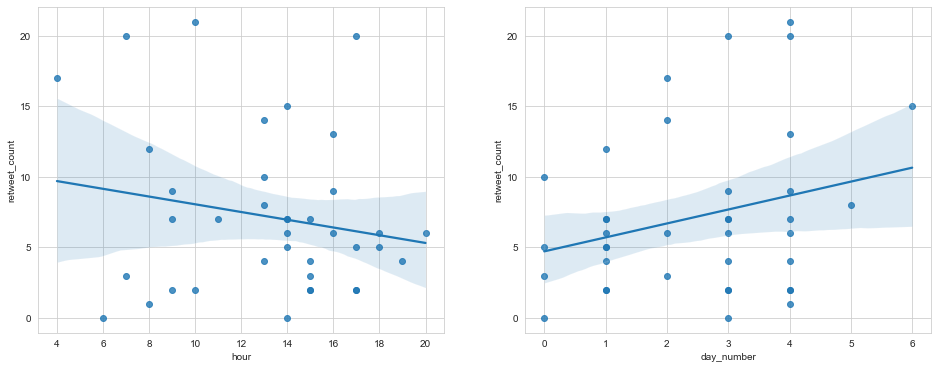

In [665]:
#Set style
sns.set_style('whitegrid')

#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Scatterplots including reg line
sns.regplot(x='hour', y='retweet_count', data=clean_df, ax=ax1)
sns.regplot(x='day_number', y='retweet_count', data=clean_df, ax=ax2);

#Set xaxisticklabels to integer
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

**Favorites**

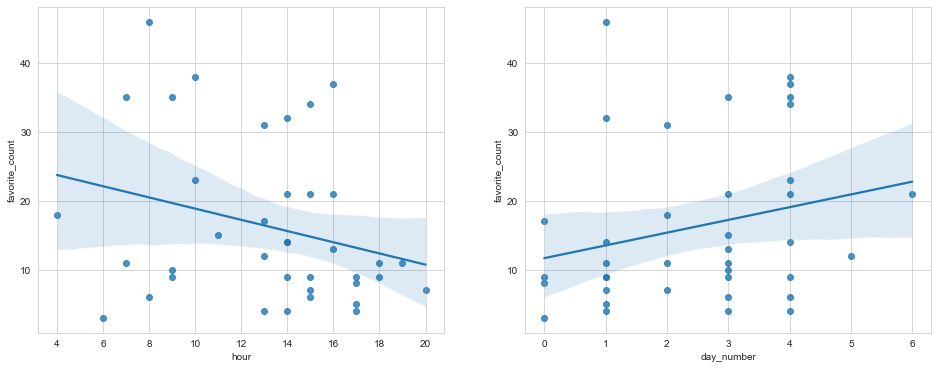

In [666]:
#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Scatterplots including reg line
sns.regplot(x='hour', y='favorite_count', data=clean_df, ax=ax1)
sns.regplot(x='day_number', y='favorite_count', data=clean_df, ax=ax2);

#Set xaxisticklabels to integer
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

**Day of week**

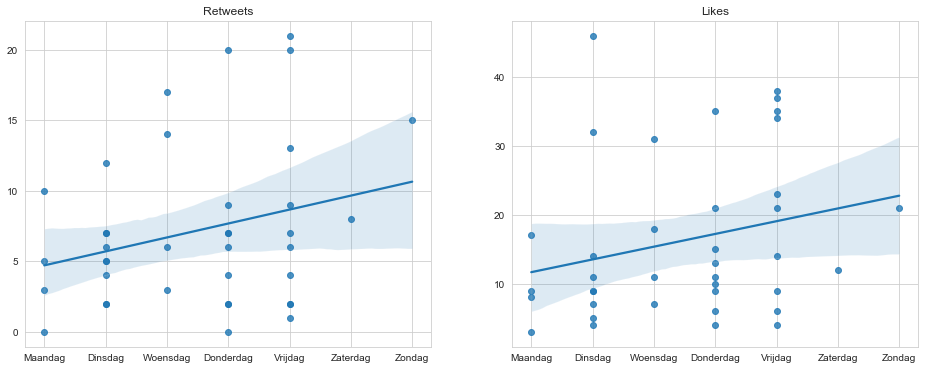

In [664]:
#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Scatterplot including reg line
sns.regplot(x='day_number', y='retweet_count', data=clean_df, ax=ax1)

#Format chart
ax1.set_xticklabels(['Maandag', 'Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title('Retweets')

#Scatterplot including reg line
sns.regplot(x='day_number', y='favorite_count', data=clean_df, ax=ax2);

#Format chart
ax2.set_xticklabels(['Maandag', 'Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title('Likes');

**Average per hour**

In [678]:
#Group by hour and capture average values
group_by_hour = (clean_df
                   .groupby('hour')
                   .mean()
                )

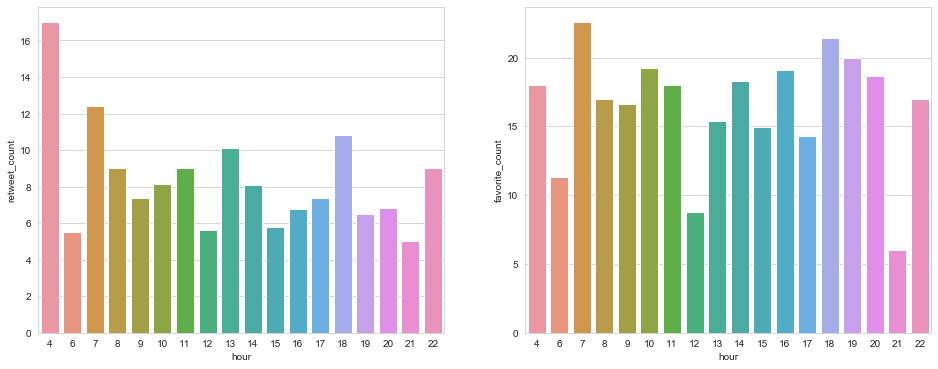

In [679]:
#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Plot barcharts
sns.barplot(x=group_by_hour.index, y='retweet_count', data=group_by_hour, ax=ax1)
sns.barplot(x=group_by_hour.index, y='favorite_count', data=group_by_hour, ax=ax2);

**Average per day**

In [680]:
#Group by hour and capture average values
group_by_day = (clean_df
                   .groupby('day_number')
                   .mean()
               )

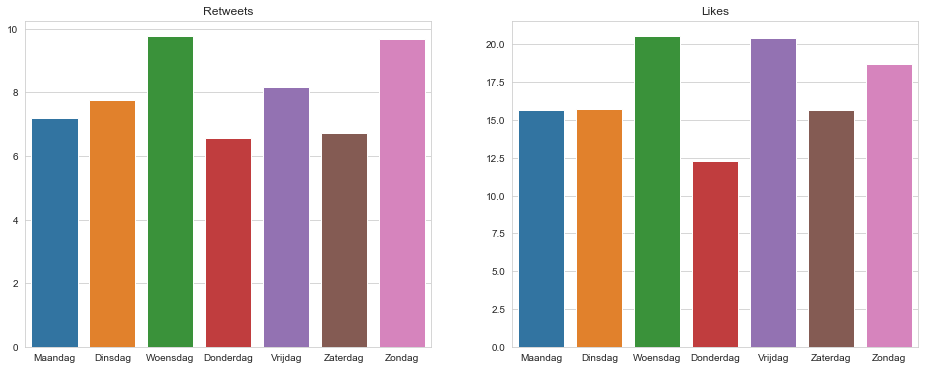

In [681]:
#Create subplot to plot on
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

#Plot retweets per day
sns.barplot(x=group_by_day.index, y='retweet_count', data=group_by_day, ax=ax1)

#Format chart
ax1.set_xticklabels(['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title('Retweets')

#Plot favorites/likes per day
sns.barplot(x=group_by_day.index, y='favorite_count', data=group_by_day, ax=ax2)

#Format chart
ax2.set_xticklabels(['Maandag', 'Dinsdag', 'Woensdag', 'Donderdag', 'Vrijdag', 'Zaterdag', 'Zondag'])
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_title('Likes');

## Correlation & regression

- Negative correlation between hour and retweet/favorite count
- Positive correlation between day number and retweet/favorite count

In [682]:
#Corrlation df 
(clean_df
 .corr()
 .loc[['retweet_count', 'favorite_count'], ['hour', 'day_number']]
)

,hour,day_number
retweet_count,-0.07994,0.018407
favorite_count,0.01539,0.054771


**Retweets**

In [683]:
#Define explanatory variables
X = clean_df[['hour', 'day_number']]

#Define dependent variable
y_retweet = clean_df['retweet_count']

In [684]:
#Initiate OLS regression object
reg_retweets_ols = OLS(y_retweet, X)

In [685]:
#Fit OLS model
results_retweets_ols = reg_retweets_ols.fit()

- We observe a positive effect of posting later on the day for retweets on @minbz
- We observe a positive effect of posting later in the week for retweets on @minBZ

In [686]:
#Evaluate results
results_retweets_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          retweet_count   R-squared (uncentered):                   0.582
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                              96.18
Date:                Tue, 27 Oct 2020   Prob (F-statistic):                    6.95e-27
Time:                        12:09:24   Log-Likelihood:                         -458.28
No. Observations:                 140   AIC:                                      920.6
Df Residuals:                     138   BIC:                                      926.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hour           0.4344      0.059      7.336      0.000       0.317       0.551
day_number     0.6204      0.288      2.153      0.033       0.051       1.190
==============================================================================
Omnibus:                       29.577   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.461
Skew:                           1.190   Prob(JB):                     1.64e-09
Kurtosis:                       4.129   Cond. No.                         7.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Favorites**

In [687]:
#Define dependent variable
y_favorites = clean_df['favorite_count']

In [688]:
#Initiate OLS regression object
reg_favorites_ols = OLS(y_favorites, X)

In [689]:
#Fit OLS model
results_favorites_ols = reg_favorites_ols.fit()

- We observe a positive effect of posting later on the day for favorites on @minbz
- We observe a positive effect of posting later in the week for favorites on @minBZ

In [690]:
#Evaluate results
results_favorites_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         favorite_count   R-squared (uncentered):                   0.645
Model:                            OLS   Adj. R-squared (uncentered):              0.639
Method:                 Least Squares   F-statistic:                              125.1
Date:                Tue, 27 Oct 2020   Prob (F-statistic):                    1.02e-31
Time:                        12:09:54   Log-Likelihood:                         -549.18
No. Observations:                 140   AIC:                                      1102.
Df Residuals:                     138   BIC:                                      1108.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hour           0.9558      0.113      8.432      0.000       0.732       1.180
day_number     1.3121      0.552      2.379      0.019       0.222       2.403
==============================================================================
Omnibus:                       13.129   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.861
Skew:                           0.797   Prob(JB):                     0.000593
Kurtosis:                       2.922   Cond. No.                         7.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""